<a href="https://colab.research.google.com/github/monheritier/Named-Entity-Recognition-for-Biomedical-Domain-NER-model-/blob/main/NER_for_biomedical_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Named Entity Recognition (NER) for the Biomedical Domain**
*How to identify diseases, drugs, and dosages from medical record transcriptions*

As discussed in my presentation, the extraction of Biomedical Information is an interesting research domain that deals with processing data from journals,
medical records, and other biomedical documents. Considering the availability of biomedical literature, there has been an increasing interest in extracting information, relationships, and insights from text data. However, the unstructured organization and the domain complexity of biomedical documents make these tasks hard. Fortunately, there are NLP packages that can help us in doing these tasks!

**Problem description**

Diagnostics prediction is a project which aims to automatically predict diagnostics needed for a patient with certain anamnesis.

The anamnesis is represented by a raw text file with doctor's notes about the patient, including his/her age, compaints described in free way, patient's history and so on. It is unstructured - different sections of oen patient anamnesis may abscent in another's.

The target labels are represented by the name of needed diagnostics procedure.

The value on the solution might be found in helping a doctor to find the optimal solution for diasnostics order. Patient can save time and money, and doctor can serve a patient more efficiently on sparing time for unnecessary diagnostics. Moreover, in difficult cases the algorithm may help a doctor to find a diagnosys faster, which in some cases may be extremely valuable, up to saving lives.

Theoretically some regularities found by the algorithm may help medical researchers to find the idea of treating some deseases, based on their unobvious interconnections with some symptoms.

In [ ]:
pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz

I have just installed the NER model.

In [ ]:
!pip install spacy>=3.0
!pip install Python 3
!pip install pandas 
!pip install scispacy

# **DATASET AND ENVIRONMENT PREPARATION**

Unstructured medical data, like medical transcriptions, are pretty hard to find. Usually, medical data is extremely hard to find due to HIPAA privacy regulations. So in this code I will try to find out information from a document that I'm interested in analyse in order to extract relevant information from it.
I will use a dataset of public domain which provides medical transcription that are accessible to all.

Link to dataset: 
(https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions)

In [3]:
import pandas as pd
import numpy as np
import os, sys

In [ ]:
!pip install simpletransformers

In [5]:
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch

In [7]:
med_transcript = pd.read_csv("mtsamples.csv", index_col=0)
med_transcript.info()
med_transcript.head()
print(med_transcript.shape)
med_transcript.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4999 non-null   object
 1   medical_specialty  4999 non-null   object
 2   sample_name        4999 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           3931 non-null   object
dtypes: object(5)
memory usage: 234.3+ KB
(4999, 5)


,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


The dataset has almost 5000 records, but let’s work with a small random subsample so it doesn’t take too long to process. I also have to drop any rows whose transcriptions are missing.

In [8]:
med_transcript.dropna(subset=['transcription'], inplace=True)
med_transcript_small = med_transcript.sample(n=100, replace=False, random_state=42)
med_transcript_small.info()
med_transcript_small.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 3162 to 3581
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        100 non-null    object
 1   medical_specialty  100 non-null    object
 2   sample_name        100 non-null    object
 3   transcription      100 non-null    object
 4   keywords           78 non-null     object
dtypes: object(5)
memory usage: 4.7+ KB


,description,medical_specialty,sample_name,transcription,keywords
3162,Markedly elevated PT INR despite stopping Cou...,Hematology - Oncology,Hematology Consult - 1,"HISTORY OF PRESENT ILLNESS:, The patient is w...",NaN
1981,Intercostal block from fourth to tenth interc...,Pain Management,Intercostal block - 1,"PREPROCEDURE DIAGNOSIS:, Chest pain secondary...","pain management, xylocaine, marcaine, intercos..."
1361,The patient is a 65-year-old female who under...,SOAP / Chart / Progress Notes,Lobectomy - Followup,"HISTORY OF PRESENT ILLNESS: , The patient is a...","soap / chart / progress notes, non-small cell ..."
3008,Construction of right upper arm hemodialysis ...,Nephrology,Hemodialysis Fistula Construction,"PREOPERATIVE DIAGNOSIS: , End-stage renal dise...","nephrology, end-stage renal disease, av dialys..."
4943,Bronchoscopy with brush biopsies. Persistent...,Cardiovascular / Pulmonary,Bronchoscopy - 8,"PREOPERATIVE DIAGNOSIS: , Persistent pneumonia...","cardiovascular / pulmonary, persistent pneumon..."


The dataset contains of several categories, but we will need only transcription, which is the anamnesis, and medical_specialty, which is the target disgnostics type.

In [9]:
med_transcript[['transcription', 'medical_specialty']]
med_transcript.drop(med_transcript[med_transcript['transcription'].isna()].index)

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...,...,...,...
4994,Patient having severe sinusitis about two to ...,Allergy / Immunology,Chronic Sinusitis,"HISTORY:, I had the pleasure of meeting and e...",NaN
4995,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun..."
4996,A female for a complete physical and follow u...,Allergy / Immunology,Followup on Asthma,"SUBJECTIVE: , This is a 42-year-old white fema...",NaN
4997,Mother states he has been wheezing and coughing.,Allergy / Immunology,Asthma in a 5-year-old,"CHIEF COMPLAINT: , This 5-year-old male presen...",NaN


In [12]:
data = med_transcript[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)

In [13]:
print('Sample Transcription 1:'+data.iloc[5]['transcription']+'\n')
print('Sample Transcription 2:'+data.iloc[125]['transcription']+'\n')
print('Sample Transcription 3:'+data.iloc[1000]['transcription'])

Sample Transcription 1:PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POSTOPERATIVE DIAGNOSIS:  ,Morbid obesity.,PROCEDURE: , Laparoscopic antecolic antegastric Roux-en-Y gastric bypass with EEA anastomosis.,ANESTHESIA: , General with endotracheal intubation.,INDICATION FOR PROCEDURE: , This is a 30-year-old female, who has been overweight for many years.  She has tried many different diets, but is unsuccessful.  She has been to our Bariatric Surgery Seminar, received some handouts, and signed the consent.  The risks and benefits of the procedure have been explained to the patient.,PROCEDURE IN DETAIL:  ,The patient was taken to the operating room and placed supine on the operating room table.  All pressure points were carefully padded.  She was given general anesthesia with endotracheal intubation.  SCD stockings were placed on both legs.  Foley catheter was placed for bladder decompression.  The abdomen was then prepped and draped in standard sterile surgical fashion.  Marcaine was then i

*Let’s take one transcription to see how we can work with NER:*

In [14]:
sample_transcription = med_transcript_small['transcription'].iloc[0]
print(sample_transcription[:1000]) # prints just the first 1000 characters

HISTORY OF PRESENT ILLNESS:,  The patient is well known to me for a history of iron-deficiency anemia due to chronic blood loss from colitis.  We corrected her hematocrit last year with intravenous (IV) iron.  Ultimately, she had a total proctocolectomy done on 03/14/2007 to treat her colitis.  Her course has been very complicated since then with needing multiple surgeries for removal of hematoma.  This is partly because she was on anticoagulation for a right arm deep venous thrombosis (DVT) she had early this year, complicated by septic phlebitis.,Chart was reviewed, and I will not reiterate her complex history.,I am asked to see the patient again because of concerns for coagulopathy.,She had surgery again last month to evacuate a pelvic hematoma, and was found to have vancomycin resistant enterococcus, for which she is on multiple antibiotics and followed by infectious disease now.,She is on total parenteral nutrition (TPN) as well.,LABORATORY DATA:,  Labs today showed a white blood 

Hence, we can see a lot of entities in this transcription. There are drug, disease, and exam names for example. The text was scraped from a web page and we can identify the different sections from the medical record like “HISTORY OF PRESENT ILLNESS” and “LABORATORY DATA”, but this varies from record to record.

In [15]:
med_transcript['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

Classes are deeply imbalanced. For 5000 objects it might be too much. We will check it later.

Let's check the sentence structure

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

from imblearn.over_sampling import SMOTE
import nltk
nltk.download('punkt')

In [17]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1 
    word_count = len(vocab.keys())
    return sent_count,word_count

In [18]:
clinical_text_df = data[data['transcription'].notna()]
sent_count,word_count= get_sentence_word_count(clinical_text_df['transcription'].tolist())
print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))



data_categories  = clinical_text_df.groupby(clinical_text_df['medical_specialty'])
i = 1
print('===========Original Categories =======================')
for catName,dataCategory in data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1
print('==================================')

Number of sentences in transcriptions column: 140214
Number of unique words in transcriptions column: 35833
===========Original Categories =======================
Cat:1  Allergy / Immunology : 7
Cat:2  Autopsy : 8
Cat:3  Bariatrics : 18
Cat:4  Cardiovascular / Pulmonary : 371
Cat:5  Chiropractic : 14
Cat:6  Consult - History and Phy. : 516
Cat:7  Cosmetic / Plastic Surgery : 27
Cat:8  Dentistry : 27
Cat:9  Dermatology : 29
Cat:10  Diets and Nutritions : 10
Cat:11  Discharge Summary : 108
Cat:12  ENT - Otolaryngology : 96
Cat:13  Emergency Room Reports : 75
Cat:14  Endocrinology : 19
Cat:15  Gastroenterology : 224
Cat:16  General Medicine : 259
Cat:17  Hematology - Oncology : 90
Cat:18  Hospice - Palliative Care : 6
Cat:19  IME-QME-Work Comp etc. : 16
Cat:20  Lab Medicine - Pathology : 8
Cat:21  Letters : 23
Cat:22  Nephrology : 81
Cat:23  Neurology : 223
Cat:24  Neurosurgery : 94
Cat:25  Obstetrics / Gynecology : 155
Cat:26  Office Notes : 50
Cat:27  Ophthalmology : 83
Cat:28  Orthoped

Since some catgeories have less than 50 samples i remove them.

In [19]:
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 50)
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
i=1
print('============Reduced Categories ======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============ Reduced Categories ======================')

============Reduced Categories ======================
Cat:1  Cardiovascular / Pulmonary : 371
Cat:2  Consult - History and Phy. : 516
Cat:3  Discharge Summary : 108
Cat:4  ENT - Otolaryngology : 96
Cat:5  Emergency Room Reports : 75
Cat:6  Gastroenterology : 224
Cat:7  General Medicine : 259
Cat:8  Hematology - Oncology : 90
Cat:9  Nephrology : 81
Cat:10  Neurology : 223
Cat:11  Neurosurgery : 94
Cat:12  Obstetrics / Gynecology : 155
Cat:13  Ophthalmology : 83
Cat:14  Orthopedic : 355
Cat:15  Pain Management : 61
Cat:16  Pediatrics - Neonatal : 70
Cat:17  Psychiatry / Psychology : 53
Cat:18  Radiology : 273
Cat:19  SOAP / Chart / Progress Notes : 166
Cat:20  Surgery : 1088
Cat:21  Urology : 156
============ Reduced Categories ======================


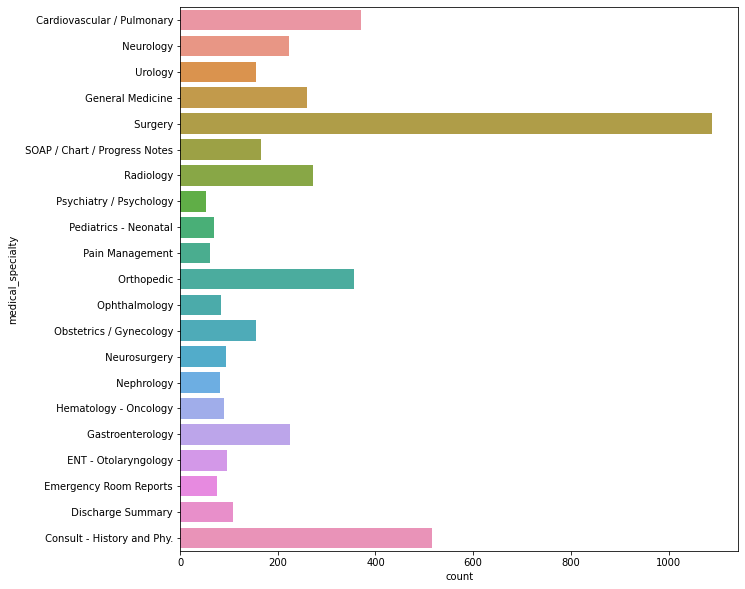

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = filtered_data_categories )
plt.show()

In [30]:
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import RegexpTokenizer

In [23]:
from keras.preprocessing.sequence import pad_sequences

In [31]:
# Create a list of tokens for each sentence
tokenizer = RegexpTokenizer(r'\w+')
data["tokens"] = data["transcription"].apply(tokenizer.tokenize)

all_words = [word for tokens in data["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

2420937 words total, with a vocabulary size of 28581
Max sentence length is 3114


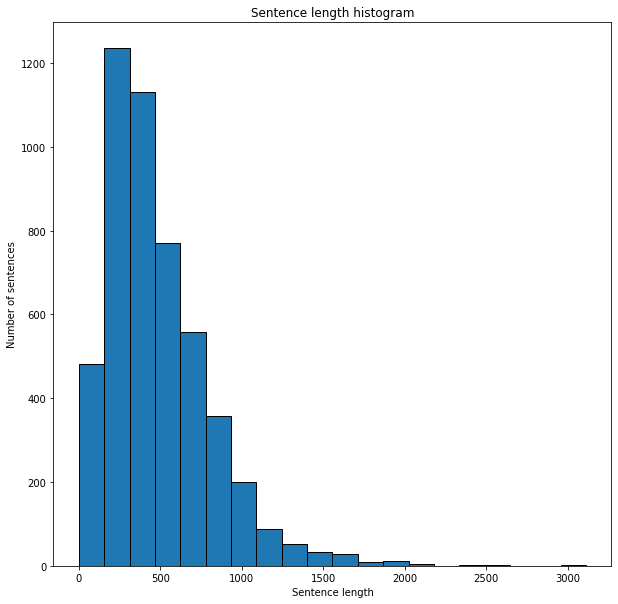

In [32]:
fig = plt.figure(figsize=(10, 10)) 
plt.title('Sentence length histogram')
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths, edgecolor = 'black', bins = 20)
plt.show()

In [33]:
print(f"Median sentence length {np.median(sentence_lengths)}")
print(f"Mean sentence length {round(np.mean(sentence_lengths), 2)}")

Median sentence length 421.5
Mean sentence length 487.5


Average sentence is long enough: median and mean values are over 400 words.

# **CLEANING THE DATA**

In [34]:
import string
def clean_text(text ): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()]) 
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    
    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text2 = BAD_SYMBOLS_RE.sub('', text2)
    return text2

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    intial_sentences= sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]
    
    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))       
    return ' '.join(wordlist) 

In [ ]:
import re
nltk.download('wordnet')
data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)

In [37]:
print('Sample Transcription 1:'+data.iloc[5]['transcription']+'\n')
print('Sample Transcription 2:'+data.iloc[125]['transcription']+'\n')
print('Sample Transcription 3:'+data.iloc[1000]['transcription'])

Sample Transcription 1:preoperative diagnosis   morbid obesity   indication for procedure   this is a yearold female  who ha been overweight for many year 

Sample Transcription 2:there is normal and symmetrical filling of the caliceal system  there is normal and symmetrical filling of the caliceal system 

Sample Transcription 3:indication   rectal bleeding  constipation  abnormal ct scan  rule out inflammatory bowel disease   premedication   see procedure nurse ncs form 


We have in this way extracted the keyword of each transcription.

In [38]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names())
print(feature_names)

['abc', 'abc yearold', 'abcd', 'abcd general', 'abcd general hospital', 'abdomen', 'abdomen pelvis', 'abdominal', 'abdominal pain', 'abnormal', 'abscess', 'accident', 'activity', 'acute', 'address', 'adenocarcinoma', 'adequate', 'administered', 'admission', 'admission diagnoses', 'admission diagnoses admission', 'admission diagnosis', 'admitted', 'admitted hospital', 'admitting', 'admitting diagnoses', 'admitting diagnosis', 'africanamerican', 'africanamerican female', 'africanamerican male', 'age', 'ago', 'airway', 'alert', 'allergy', 'alternative', 'anemia', 'anesthesia', 'anesthesia general', 'anesthesia wa', 'anesthetic', 'angina', 'angiography', 'ankle', 'anterior', 'antibiotic', 'aortic', 'apnea', 'apparent', 'appendicitis', 'applied', 'appointment', 'appropriate', 'approximately', 'area', 'arm', 'artery', 'artery disease', 'arthritis', 'asked', 'aspect', 'aspiration', 'associated', 'asthma', 'atrial', 'atrial fibrillation', 'awake', 'axial', 'baby', 'base', 'began', 'benefit', '

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


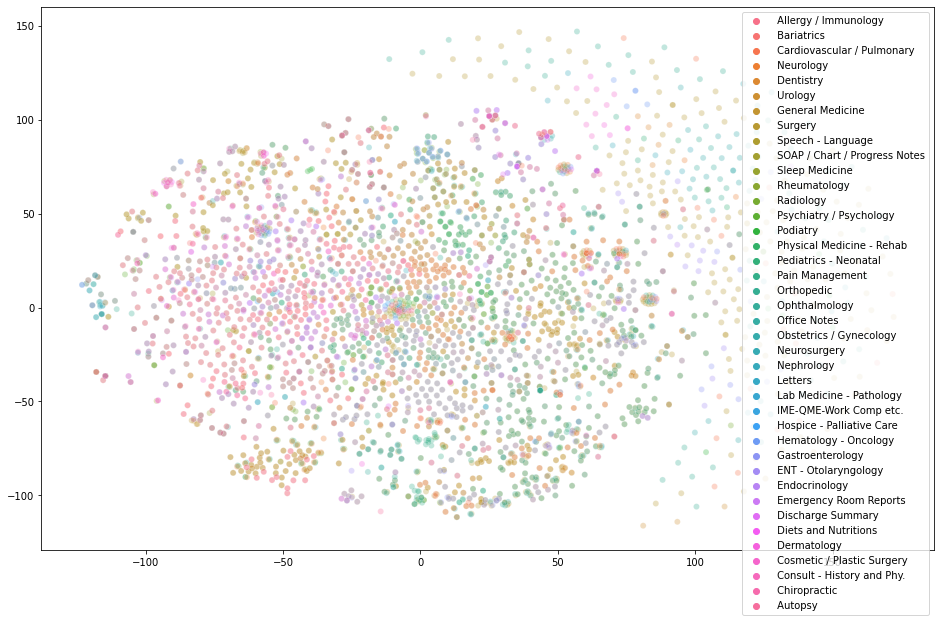

In [39]:
import gc
gc.collect()
tfIdfMatrix = tfIdfMat.todense()
labels = data['medical_specialty'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(16,10))

sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    legend="full",
    alpha=0.3
)
plt.show()

I can apply PCA to reduce the dimensionality of the features

In [40]:
gc.collect()
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)

In [41]:
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(3724, 544)
Test_Set_Size:(1242, 544)


Let's use Logistic regression to evaluate the performance of the training on test.

In [42]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

In [43]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

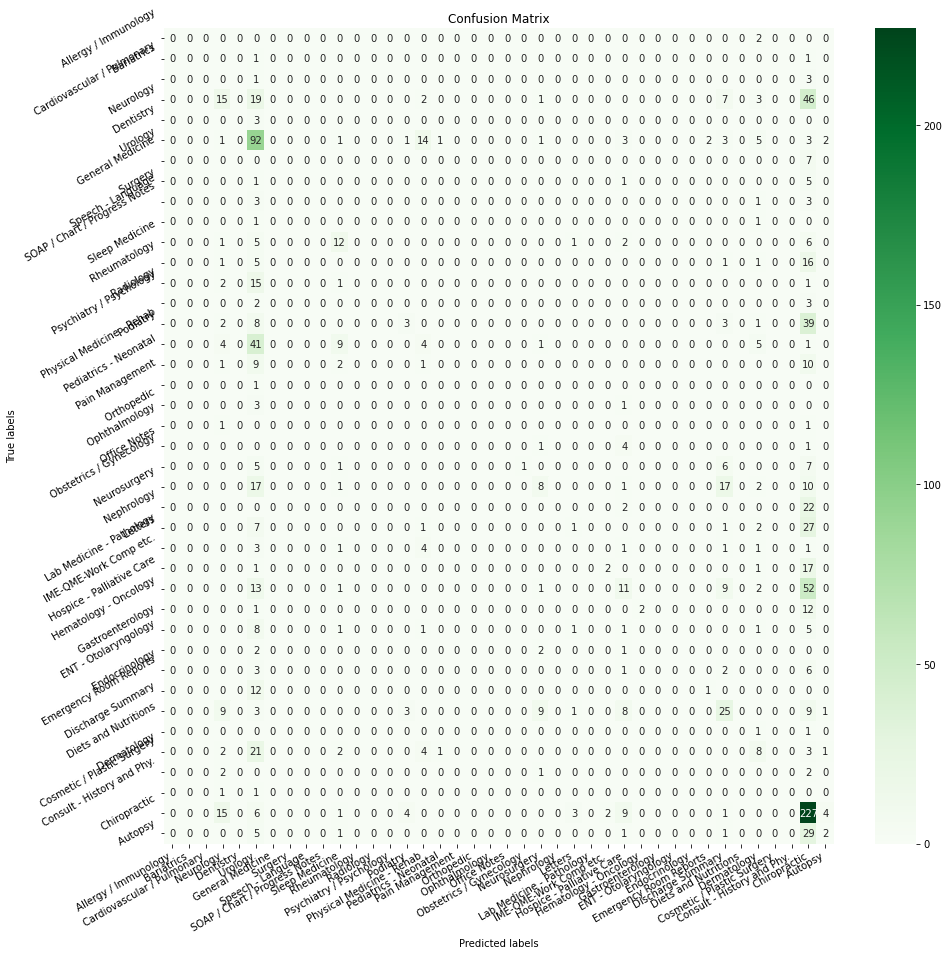

In [44]:
fig = plt.figure(figsize=(15,15))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')    
plt.show()

In [45]:
print(classification_report(y_test,y_test_pred,labels=category_list))

                                precision    recall  f1-score   support

          Allergy / Immunology       0.00      0.00      0.00         2
                    Bariatrics       0.00      0.00      0.00         4
    Cardiovascular / Pulmonary       0.26      0.16      0.20        93
                     Neurology       0.32      0.14      0.20        56
                     Dentistry       0.00      0.00      0.00         7
                       Urology       0.20      0.05      0.08        39
              General Medicine       0.13      0.06      0.08        65
                       Surgery       0.39      0.83      0.54       272
             Speech - Language       0.00      0.00      0.00         2
 SOAP / Chart / Progress Notes       0.22      0.19      0.20        42
                Sleep Medicine       0.00      0.00      0.00         5
                  Rheumatology       0.00      0.00      0.00         2
                     Radiology       0.32      0.37      0.34  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The results are quite poor. Let us apply some domain knowledge and see if we can improve the results The surgey category is kind of superset as there can be surgeries belonging to specializations like cardiology,neurolrogy etc. Similarly other categories like Emergency Room Reports, Discharge Summary, hence i remove them.

In [46]:
filtered_data_categories['medical_specialty'] =filtered_data_categories['medical_specialty'].apply(lambda x:str.strip(x))
mask = filtered_data_categories['medical_specialty'] == 'Surgery'
filtered_data_categories = filtered_data_categories[~mask]
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
mask = filtered_data_categories['medical_specialty'] == 'SOAP / Chart / Progress Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Office Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Consult - History and Phy.'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Emergency Room Reports'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Discharge Summary'
filtered_data_categories = filtered_data_categories[~mask]

'''
mask = filtered_data_categories['medical_specialty'] == 'Pediatrics - Neonatal'
filtered_data_categories = filtered_data_categories[~mask]
'''
mask = filtered_data_categories['medical_specialty'] == 'Pain Management'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'General Medicine'
filtered_data_categories = filtered_data_categories[~mask]


mask = filtered_data_categories['medical_specialty'] == 'Neurosurgery'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Neurology'
mask = filtered_data_categories['medical_specialty'] == 'Nephrology'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Urology'


i=1
print('============Reduced Categories======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============Reduced Categories======================')


data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

============Reduced Categories======================
Cat:1 Cardiovascular / Pulmonary : 371
Cat:2 Consult - History and Phy. : 516
Cat:3 Discharge Summary : 108
Cat:4 ENT - Otolaryngology : 96
Cat:5 Emergency Room Reports : 75
Cat:6 Gastroenterology : 224
Cat:7 General Medicine : 259
Cat:8 Hematology - Oncology : 90
Cat:9 Nephrology : 81
Cat:10 Neurology : 223
Cat:11 Neurosurgery : 94
Cat:12 Obstetrics / Gynecology : 155
Cat:13 Ophthalmology : 83
Cat:14 Orthopedic : 355
Cat:15 Pain Management : 61
Cat:16 Pediatrics - Neonatal : 70
Cat:17 Psychiatry / Psychology : 53
Cat:18 Radiology : 273
Cat:19 SOAP / Chart / Progress Notes : 166
Cat:20 Urology : 156
============Reduced Categories======================


(2324, 2)

# **NAMED ENTITY RECOGNTITION**

Named entity recognition (NER) is a subtask of natural language processing used to identify and classify named entities mentioned in unstructured text into pre-defined categories. 

scispacy presents a lot of model. I'm going to text now the Scibert model, which is a full spaCy pipeline for biomedical data with a ~785k vocabulary and allenai/scibert-base as the transformer model.

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_core_sci_scibert-0.5.0.tar.gz

In [ ]:
import scispacy
import spacy
nlp = spacy.load("en_core_sci_scibert")

In [55]:
doc = nlp(sample_transcription) #document n. 0
print("TEXT", "START", "END", "ENTITY TYPE")
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

TEXT START END ENTITY TYPE
iron-deficiency anemia 79 101 DISEASE
chronic blood loss 109 127 DISEASE
colitis 133 140 DISEASE
iron 203 207 CHEMICAL
colitis 286 293 DISEASE
hematoma 391 399 DISEASE
venous thrombosis 473 490 DISEASE
DVT 492 495 DISEASE
pelvic hematoma 742 757 DISEASE
vancomycin 781 791 CHEMICAL
infectious disease 873 891 DISEASE
improved.,PT 1348 1360 CHEMICAL
vitamin K 1503 1512 CHEMICAL
uric acid 1830 1839 CHEMICAL
bilirubin 1853 1862 CHEMICAL
Creatinine 1911 1921 CHEMICAL
creatinine 1951 1961 CHEMICAL
Folic acid 2079 2089 CHEMICAL
Iron 2103 2107 CHEMICAL
heparin 2322 2329 CHEMICAL
loperamide 2339 2349 CHEMICAL
niacin 2351 2357 CHEMICAL
pantoprazole 2359 2371 CHEMICAL
Diovan 2373 2379 CHEMICAL
Afrin 2381 2386 CHEMICAL
caspofungin 2400 2411 CHEMICAL
daptomycin 2413 2423 CHEMICAL
Ertapenem 2425 2434 CHEMICAL
fentanyl 2436 2444 CHEMICAL
morphine 2448 2456 CHEMICAL
pain 2464 2468 DISEASE
Compazine 2474 2483 CHEMICAL
Zofran 2487 2493 CHEMICAL
epistaxis 2629 2638 DISEASE
bleed

We can see the model correctly identified and label diseases such as iron-deficiency anemia, chronic blood loss, and many more. Lots of drugs were also identified, like vancomycin, Compazine, Zofran. The model can also identify common laboratory tested molecules such as creatinine, iron, bilirubin, uric acid. But something is missing anyway.

In fact, some labels are classified weirdly, possibly due to punctuation marks.

infections.,I 4826 4839 ENTITY
noted.,ABDOMEN 2894 2908 ENTITY

Punctuation marks are usually removed in NLP preprocessing steps, but we can’t remove all of them here, otherwise, we may miss chemical names and would screw up quantities like drug dosage. 
However, let's solve this problem by removing the “.,” marks that appear to separate some sections of the transcription.

In [56]:
import re

med_transcript_small['transcription'] = med_transcript_small['transcription'].apply(lambda x: re.sub('(\.,)', ". ", x))

from spacy import displacy
displacy.render(doc[:100], style='ent', jupyter=True) # here I am printing just the first 100 tokens

# **RULE BASE MATCHED**

Rule-based matching is similar to regular expressions, but spaCy’s rule-based matcher engines and components give you access to the tokens within the document and their relationships. We can combine this with the NER models to identify some pattern that includes our entities. Let’s extract from the text the drug names and their reported dosages. This could be of real use to identify possible medication errors by checking if the dosages are in accordance with standards and guidelines.

In [57]:
from spacy.matcher import Matcher

pattern = [{'ENT_TYPE':'CHEMICAL'}, {'LIKE_NUM': True}, {'IS_ASCII': True}]
matcher = Matcher(nlp.vocab)
matcher.add("DRUG_DOSE", [pattern])

The code above creates a pattern to identify a sequence of three tokens:

* A token whose entity type is CHEMICAL (drug name)
* A token that resembles a number (dosage)
* A token that consists of ASCII characters (units, like mg or mL)

Then I initialize the Matcher with a vocabulary. The matcher must always share the same vocab with the documents it will operate on, so we use the nlp object vocab. Then I add this pattern to the matcher and give it an ID.

Now we can loop through all transcriptions and extract the text matching this pattern:

In [58]:
for transcription in med_transcript_small['transcription']:
    doc = nlp(transcription)
    matches = matcher(doc)
    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]  # get string representation
        span = doc[start:end]  # the matched span
        print(string_id, start, end, span.text)

DRUG_DOSE 137 140 Xylocaine 20 mL
DRUG_DOSE 141 144 Marcaine 0.25%
DRUG_DOSE 208 211 Aspirin 81 mg
DRUG_DOSE 216 219 Spiriva 10 mcg
DRUG_DOSE 399 402 nifedipine 10 mg
DRUG_DOSE 226 229 aspirin one tablet
DRUG_DOSE 245 248 Warfarin 2.5 mg
DRUG_DOSE 67 70 Topamax 100 mg
DRUG_DOSE 73 76 Zoloft 100 mg
DRUG_DOSE 79 82 Abilify 5 mg
DRUG_DOSE 84 87 Motrin 800 mg
DRUG_DOSE 110 113 Xanax 1 mg
DRUG_DOSE 125 128 Colace 100 mg
DRUG_DOSE 168 171 Paxil 10 mg
DRUG_DOSE 175 178 Prednisone 20 mg
DRUG_DOSE 193 196 Metamucil one pack
DRUG_DOSE 207 210 Nexium 40 mg
DRUG_DOSE 1133 1136 Naprosyn one p.o
DRUG_DOSE 290 293 Lidocaine 1%
DRUG_DOSE 37 40 Altrua 60,
DRUG_DOSE 239 242 lidocaine 2%
DRUG_DOSE 97 100 Creatinine 1.3,
DRUG_DOSE 100 103 sodium 141,
DRUG_DOSE 104 107 potassium 4.0.
DRUG_DOSE 108 111 Calcium 8.6.
DRUG_DOSE 440 443 aspirin 81 mg
DRUG_DOSE 447 450 Lipitor 20 mg
DRUG_DOSE 454 457 Klonopin 0.5 mg
DRUG_DOSE 462 465 digoxin 0.125 mg
DRUG_DOSE 469 472 Lexapro 10 mg
DRUG_DOSE 484 487 Lasix 20 mg


Hence, I have successfully extracted drugs and dosages, including different kinds of units like mg, mL, %, packs.

Let's try the same task on other transcription using another model from spacy library.

We are going to use the NER model trained on the BC5CDR corpus (en_ner_bc5cdr_md). This corpus consists of 1500 PubMed articles with 4409 annotated chemicals, 5818 diseases, and 3116 chemical-disease interactions. 

In [ ]:
nlp = spacy.load("en_ner_bc5cdr_md")

In [73]:
sample_transcription1 = med_transcript_small['transcription'].iloc[3]
doc = nlp(sample_transcription1)
print("TEXT", "START", "END", "ENTITY TYPE")
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

TEXT START END ENTITY TYPE
End-stage renal disease 26 49 DISEASE
fistula 75 82 DISEASE
End-stage renal disease 111 134 DISEASE
fistula 160 167 DISEASE
fistula 227 234 DISEASE
fistula 990 997 DISEASE
fistula 1131 1138 DISEASE
cephalic vein fistula 1310 1331 DISEASE
fistula 1409 1416 DISEASE
brachial vein end 1511 1528 DISEASE
branchial vein to arterialized fistula 1562 1600 DISEASE
fistula 1739 1746 DISEASE
inferior skin stab incision 1986 2013 DISEASE
blood loss 2295 2305 DISEASE


In [74]:
med_transcript_small['transcription'] = med_transcript_small['transcription'].apply(lambda x: re.sub('(\.,)', ". ", x))

In [76]:
displacy.render(doc[:300], style='ent', jupyter=True) 

In [77]:
pattern = [{'ENT_TYPE':'CHEMICAL'}, {'LIKE_NUM': True}, {'IS_ASCII': True}]
matcher = Matcher(nlp.vocab)
matcher.add("DRUG_DOSE", [pattern])

In [78]:
for transcription in med_transcript_small['transcription']:
    doc = nlp(transcription)
    matches = matcher(doc)
    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]  # get string representation
        span = doc[start:end]  # the matched span
        print(string_id, start, end, span.text)

DRUG_DOSE 137 140 Xylocaine 20 mL
DRUG_DOSE 141 144 Marcaine 0.25%
DRUG_DOSE 208 211 Aspirin 81 mg
DRUG_DOSE 216 219 Spiriva 10 mcg
DRUG_DOSE 399 402 nifedipine 10 mg
DRUG_DOSE 226 229 aspirin one tablet
DRUG_DOSE 245 248 Warfarin 2.5 mg
DRUG_DOSE 67 70 Topamax 100 mg
DRUG_DOSE 73 76 Zoloft 100 mg
DRUG_DOSE 79 82 Abilify 5 mg
DRUG_DOSE 84 87 Motrin 800 mg
DRUG_DOSE 110 113 Xanax 1 mg
DRUG_DOSE 125 128 Colace 100 mg
DRUG_DOSE 168 171 Paxil 10 mg
DRUG_DOSE 175 178 Prednisone 20 mg
DRUG_DOSE 193 196 Metamucil one pack
DRUG_DOSE 207 210 Nexium 40 mg
DRUG_DOSE 1133 1136 Naprosyn one p.o
DRUG_DOSE 290 293 Lidocaine 1%
DRUG_DOSE 37 40 Altrua 60,
DRUG_DOSE 239 242 lidocaine 2%
DRUG_DOSE 97 100 Creatinine 1.3,
DRUG_DOSE 100 103 sodium 141,
DRUG_DOSE 104 107 potassium 4.0.
DRUG_DOSE 108 111 Calcium 8.6.
DRUG_DOSE 440 443 aspirin 81 mg
DRUG_DOSE 447 450 Lipitor 20 mg
DRUG_DOSE 454 457 Klonopin 0.5 mg
DRUG_DOSE 462 465 digoxin 0.125 mg
DRUG_DOSE 469 472 Lexapro 10 mg
DRUG_DOSE 484 487 Lasix 20 mg


**BUT WHAT IF I WANT TO DEAL WITH THE MEDICAL ENTITIES OF EACH TRANSCRIPTION CONTAINED IN THE DATASET?**

In [59]:
def process_Text( text):
    wordlist=[]
    doc = nlp(text)
    for ent in doc.ents:
        wordlist.append(ent.text)
    return ' '.join(wordlist) 

In [60]:
data['transcription'] = data['transcription'].apply(process_Text)
data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)

In [61]:
print('Sample Transcription 1:'+data.iloc[5]['transcription']+'\n')
print('Sample Transcription 2:'+data.iloc[125]['transcription']+'\n')
print('Sample Transcription 3:'+data.iloc[1000]['transcription'])

Sample Transcription 1:cc confusion slurred flulike illness  outburst of anger right facial weakness headache nausea vomiting fever chill migraine unremarkable  shx tobaccoillicit tc  ms weakness unremarkable  reflexes bue  ble gs ua hypodensities edema mca vasculopathy fibromuscular dysplasia hiv  ana b cholesterol unremarkable  she mca mca mca mca vasculitis moya disease cognitive dysfunction particular impairment of language function right hemiparesis neck lymphadenopathy stage iv squamous cell cancer of the cervix cervical cancer

Sample Transcription 2:hematuria hematuria abnormal appearing right kidney hypospadias upj obstruction papillary mass within the collecting

Sample Transcription 3:vaginal hysterectomy  anesthesia tooth tenaculum uterine cervix marcaine epinephrine carbon dioxide marcaine epinephrine endometriosis bipolar electrocautery bipolar electrocautery bipolar electrocautery bipolar electrocautery marcaine epinephrine bleeding bleeding bleeding carbon dioxide neosp

Let's redo the same process done previously in this notebook, then perform dimensionality reduction on the features using t-sne and plot the t-sne features

In [62]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75,min_df=5, use_idf=True, smooth_idf=True,sublinear_tf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names())
print(feature_names)

['abdomen', 'abdomen edema', 'abdominal', 'abdominal pain', 'abdominal pain nausea', 'abnormal', 'abnormality', 'abscess', 'abuse', 'acid', 'acl', 'acute', 'adenocarcinoma', 'adenocarcinoma prostate', 'adenoid', 'adenoma', 'adenopathy', 'adenosine', 'adhesion', 'adnexa', 'adnexal', 'adrenal', 'advair', 'afebrile', 'air', 'airway', 'albuterol', 'alcohol', 'alcohol abuse', 'allergic', 'allergies', 'allergies social', 'allergy', 'alzheimer', 'ambien', 'amoxicillin', 'ana', 'ancef', 'anemia', 'anesthesia', 'aneurysm', 'aneurysm aneurysm', 'angina', 'ankle', 'anterior', 'anus', 'anxiety', 'aorta', 'aortic', 'aphasia', 'apnea', 'appendicitis', 'arrhythmia', 'artery', 'artery disease', 'arthritis', 'arthrosis', 'asa', 'ascites', 'aspirin', 'aspirin plavix', 'assessment', 'ataxia', 'atelectasis', 'atenolol', 'atherosclerosis', 'atherosclerotic', 'ativan', 'atrial', 'atrial enlargement', 'atrial fibrillation', 'atrial fibrillation atrial', 'atrophy', 'attention', 'auditory', 'av', 'axis', 'axis

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


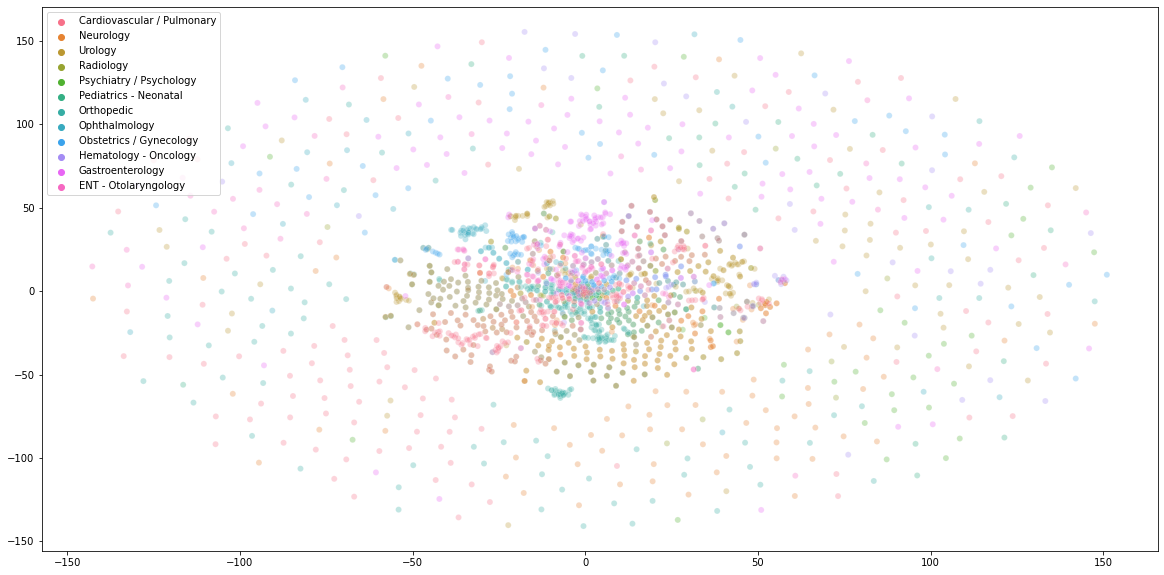

In [64]:
import gc
gc.collect()
tfIdfMatrix = tfIdfMat.todense()
labels = data['medical_specialty'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(20,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    legend="full",
    alpha=0.3
)
plt.show()

In [65]:
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()

In [66]:
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)   
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(1743, 567)
Test_Set_Size:(581, 567)


In [67]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

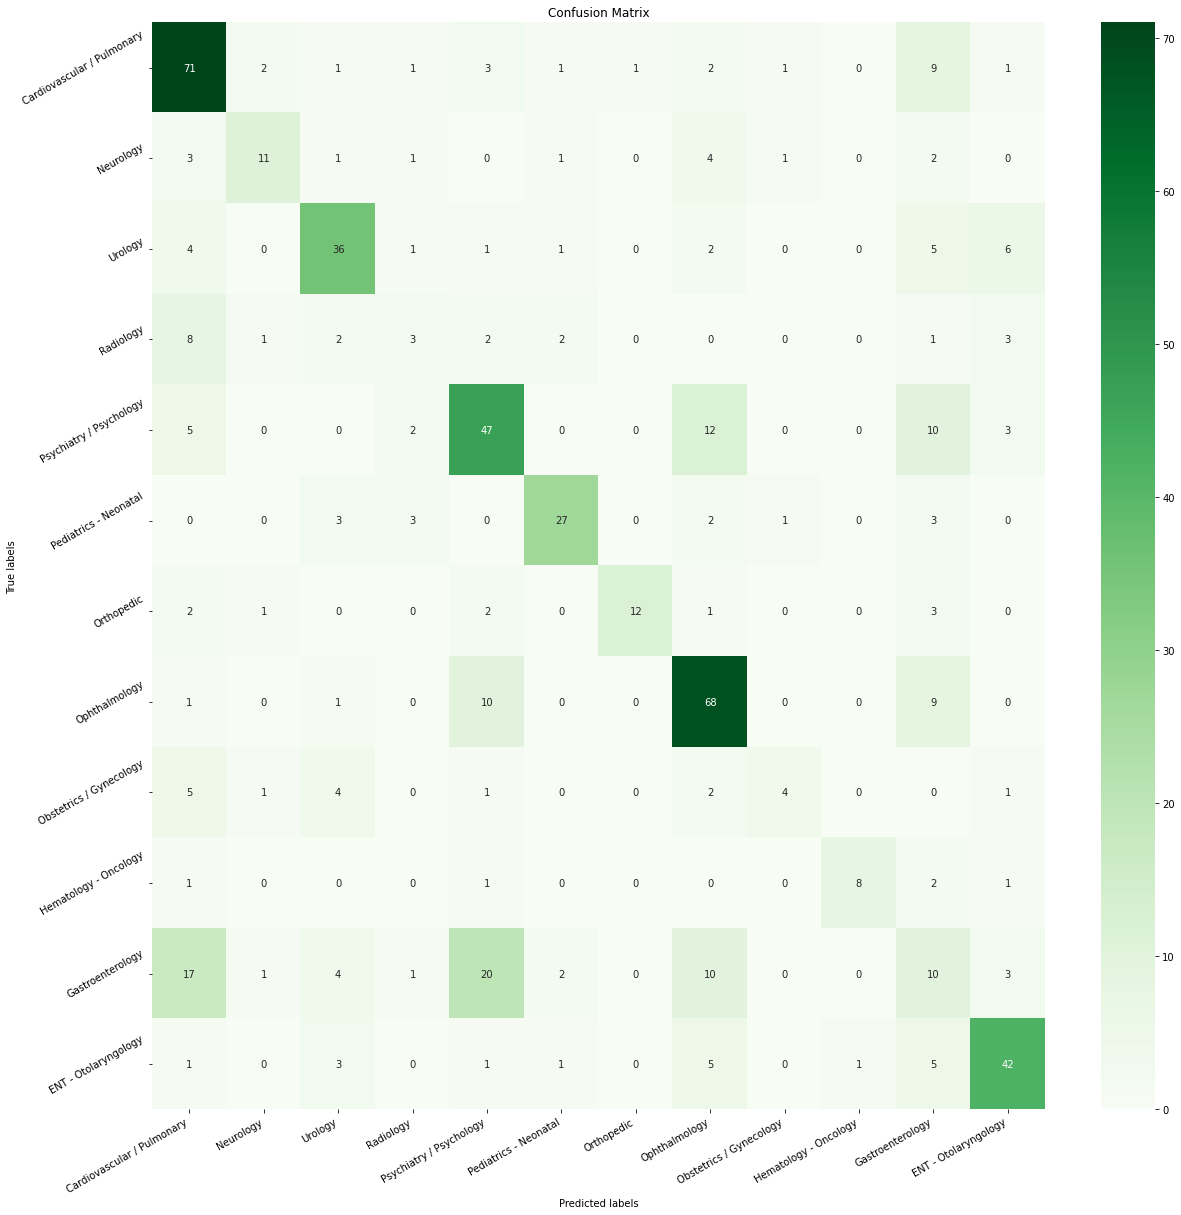

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.60      0.76      0.67        93
                 Neurology       0.53      0.59      0.56        79
                   Urology       0.70      0.71      0.71        59
                 Radiology       0.17      0.15      0.16        68
   Psychiatry / Psychology       0.89      0.62      0.73        13
     Pediatrics - Neonatal       0.57      0.22      0.32        18
                Orthopedic       0.63      0.76      0.69        89
             Ophthalmology       0.92      0.57      0.71        21
   Obstetrics / Gynecology       0.77      0.69      0.73        39
     Hematology - Oncology       0.25      0.14      0.18        22
          Gastroenterology       0.65      0.64      0.65        56
      ENT - Otolaryngology       0.65      0.46      0.54        24

                  accuracy                           0.58       581
                 macro avg       0.61      0.5

In [68]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

There is an improvement on the performances but still some categories are not getting classified properly. Let us look at samples from these classes:

In [69]:
mask = filtered_data_categories['medical_specialty'] == 'Radiology'
radiologyData = filtered_data_categories[mask]
print(radiologyData['transcription'].tolist()[1])

EXAM: , Two views of the soft tissues of the neck.,HISTORY:,  Patient has swelling of the left side of his neck.,TECHNIQUE:,  Frontal and lateral views of the soft tissues of the neck were evaluated. There were no soft tissues of the neck radiographs for comparison. However, there was an ultrasound of the neck performed on the same day.,FINDINGS: , Frontal and lateral views of the soft tissues of the neck were evaluated and reveal there is an asymmetry seen to the left-sided soft tissues of the patient's neck which appear somewhat enlarged when compared to patient's right side. However the trachea appears to be normal caliber and contour.  Lateral views show a patent airway. The adenoids and tonsils appear normal caliber without evidence of hypertrophy. Airway appears patent. Osseous structures appear grossly normal.,IMPRESSION:,1. Patent airway. No evidence of any soft tissue swelling involving the patient's adenoids/tonsils, epiglottis or aryepiglottic folds. No evidence of any preve

In [70]:
mask = clinical_text_df['medical_specialty'] ==  ' Pediatrics - Neonatal'
pediaData = clinical_text_df[mask]
print(pediaData ['transcription'].tolist()[1])

SUBJECTIVE:,  Patient presents with Mom and Dad for her 5-year 3-month well-child check.  Family has not concerns stating patient has been doing well overall since last visit.  Taking in a well-balanced diet consisting of milk and dairy products, fruits, vegetables, proteins and grains with minimal junk food and snack food.  No behavioral concerns.  Gets along well with peers as well as adults.  Is excited to start kindergarten this upcoming school year.  Does attend daycare.  Normal voiding and stooling pattern.  No concerns with hearing or vision.  Sees the dentist regularly.  Growth and development:  Denver II normal passing all developmental milestones per age in areas of fine motor, gross motor, personal and social interaction and speech and language development.  See Denver II form in the chart.,ALLERGIES:,  None.,MEDICATIONS: , None.,FAMILY SOCIAL HISTORY:,  Unchanged since last checkup.  Lives at home with mother, father and sibling.  No smoking in the home.,REVIEW OF SYSTEMS:,

In [71]:
mask = clinical_text_df['medical_specialty'] ==  ' Hematology - Oncology'
oncoData = clinical_text_df[mask]
print(oncoData ['transcription'].tolist()[1])

CHIEF COMPLAINT:,  Essential thrombocytosis.,HISTORY OF PRESENT ILLNESS: , This is an extremely pleasant 64-year-old gentleman who I am following for essential thrombocytosis.  He was first diagnosed when he first saw a hematologist on 07/09/07.  At that time, his platelet count was 1,240,000.  He was initially started on Hydrea 1000 mg q.d.  On 07/11/07, he underwent a bone marrow biopsy, which showed essential thrombocytosis.  He was positive for the JAK-2 mutation.  On 11/06/07, his platelets were noted to be 766,000.  His current Hydrea dose is now 1500 mg on Mondays and Fridays and 1000 mg on all other days.  He moved to ABCD in December 2009 in an attempt to improve his wife's rheumatoid arthritis.,Overall, he is doing well.  He has a good energy level, and his ECOG performance status is 0.  He denies any fevers, chills, or night sweats.  No lymphadenopathy.  No nausea or vomiting.  No change in bowel or bladder habits.,CURRENT MEDICATIONS: , Hydrea 1500 mg on Mondays and Fridays

# CONCLUSION

In this notebook I have presented how to extract some relevant information from different biomedical transcriptions in order to get an analysis that can be given to a doctor or someone else. I have used the features included in spacy and I have used one model from this library which is the SciBert one. I have also process data to do this operation observing that this dataset is very noisy.
Lot of text in transcriptions overlaps across categories and for this reason we can apply domain knowledge to reduce the categories.
It is un imbalanced dataset.
Hand coded features may improve results on this dataset but may not apply to generic transcription datasets.
Otherwise the NER helps us in extract the relevant information from each transcription, that in this case has been analyzed the first one, and also the rule-based match can help us to retrieve the drug dose for each medicine related to each disease.
This task could be very useful in the future of medicine since doctors could retrieve the right amount of drug to prescribe to their patients.

**Future works**

For a specific transcription, understand with NER in a faster way which drug dose the patient has to assume.